In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal
import os, sys
sys.path.append(os.path.join("/home/ra43rid/torch_plnet"))
torch.set_default_device("cuda")

class TorchMultivariateGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean' (vector), 'cov' (matrix), and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = len(self.class_params[0]["cov"])
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((X.shape[0], len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = torch.tensor(self.class_params[int(c)]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(c)]["cov"], device=self.device, dtype=torch.float32)
            prior = self.class_params[int(c)]["prior"]
            
            # Multivariate normal distribution
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            px_given_y = torch.exp(mvn_dist.log_prob(X))
            
            # Combine with prior
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]
    
    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples, n_features)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            mean = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["cov"], device=self.device, dtype=torch.float32)
            
            # Sample feature vector from the corresponding multivariate Gaussian
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            sampled_x = mvn_dist.sample()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.stack(X), torch.tensor(y, device=self.device)

class TorchGaussianSyntheticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean', 'std', and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = 1
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((len(X), len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = self.class_params[int(c)]["mean"]
            std = self.class_params[int(c)]["std"]
            prior = self.class_params[int(c)]["prior"]
            
            # Calculate Gaussian PDF: P(x|y=c)
            normal_dist = Normal(loc=mean, scale=std)
            px_given_y = torch.exp(normal_dist.log_prob(X))
            
            # Combine with prior: P(x|y=c) * P(y=c)
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]

    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples,)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            # Sample feature value from the corresponding Gaussian
            mean = self.class_params[int(self.classes_[sampled_class])]["mean"]
            std = self.class_params[int(self.classes_[sampled_class])]["std"]
            normal_dist = Normal(loc=mean, scale=std)
            sampled_x = normal_dist.sample().item()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.tensor(X, device=self.device), torch.tensor(y, device=self.device)

def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

from torchcp.classification.score import APS, THR, SAPS
aps = APS(score_type="identity", randomized=False)
rand_aps = APS(score_type="identity", randomized=True)
lac = THR(score_type="identity",)
saps = SAPS(score_type="identity",randomized=False)

class_params_1f_2c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    # 2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

class_params_1f_3c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

# Initialize and fit the generator
class_params_2d_3c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
            # [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
            # [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4],
            [0.4, 1.3],
            # [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}

# Initialize and fit the generator
class_params_3d_3c = {
    0: {
        "mean": [3.0, 2.0, 4.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}


# Initialize and fit the generator
class_params_2d_2c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [2.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    # 2: {
    #     "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
    #     "cov": [
    #         [1.2, 0.4],
    #         [0.4, 1.3],
    #         # [0.3, 0.5, 1.4]
    #     ],  # Covariance matrix for class 2
    #     "prior": 0.3  # Prior probability for class 2
    # },
}

clf_1d_2c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_2c, device="cuda")
clf_1d_3c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_3c, device="cuda")
clf_3d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_3d_3c, device="cuda")
clf_2d_2c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_2c, device="cuda")

c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class OracleAnnotator:
    def __init__(self,score, generator):
        self.score = score
        self.classes_ = generator.classes_
        self.generator = generator

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.generator.predict_proba(X)
        scores = self.score(y_pred_proba, y)
        return scores

In [12]:
from zmq import device
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import torch
from scipy.stats import kendalltau
from joblib import Parallel, delayed
torch.set_default_device("cuda")

def fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate = 0.01, num_epochs=200, X_val = None, y_val = None):
    conformities = oracle_annotator.get_conformity(torch.tensor(X_train, device="cuda"),torch.tensor(y_train,device="cuda")).detach().cpu().numpy()

    sort_idx = (-conformities).argsort(axis=0).flatten()
    X_sorted = X_train[sort_idx]
    X_sorted = X_sorted.detach().cpu().numpy()
    y_sorted = y_train[sort_idx]
    conformities_sorted = conformities[sort_idx]
    
    X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
    y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
    conformity_pairs = np.array([(conformities_sorted[i], conformities_sorted[j]) for i in range(len(conformities_sorted)) for j in range(i + 1, len(conformities_sorted))])
    conformity_pairs = conformity_pairs.round(6)
    mask = conformity_pairs[:,0] == conformity_pairs[:,1]
    
    X_pairs_distinct = X_pairs[~mask]
    y_pairs_distinct = y_pairs[~mask]
    X_pairs_nondistinct = X_pairs[mask]
    y_pairs_nondistinct = y_pairs[mask]
    X_pairs_nondistinct_swp = X_pairs_nondistinct[:,::-1]
    y_pairs_nondistinct_swp = y_pairs_nondistinct[:,::-1]

    X_pairs_augmented = np.vstack((X_pairs_distinct, X_pairs_nondistinct, X_pairs_nondistinct_swp))
    y_pairs_augmented = np.vstack((y_pairs_distinct, y_pairs_nondistinct, y_pairs_nondistinct_swp))

    y_pairs_augmented = np.expand_dims(y_pairs_augmented,axis=-1)

    ds = LabelPairDataset()
    ds.create_from_numpy_pairs(X_pairs_augmented, y_pairs_augmented)


    # validation data
    if X_val is not None:
        conformities = oracle_annotator.get_conformity(torch.tensor(X_train, device="cuda"),torch.tensor(y_train,device="cuda")).detach().cpu().numpy()

        sort_idx = (-conformities).argsort(axis=0).flatten()
        X_sorted = X_train[sort_idx]
        X_sorted = X_sorted.detach().cpu().numpy()
        y_sorted = y_train[sort_idx]
        conformities_sorted = conformities[sort_idx]
        
        X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
        y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
        conformity_pairs = np.array([(conformities_sorted[i], conformities_sorted[j]) for i in range(len(conformities_sorted)) for j in range(i + 1, len(conformities_sorted))])
        conformity_pairs = conformity_pairs.round(6)
        mask = conformity_pairs[:,0] == conformity_pairs[:,1]
        
        X_pairs_distinct = X_pairs[~mask]
        y_pairs_distinct = y_pairs[~mask]
        X_pairs_nondistinct = X_pairs[mask]
        y_pairs_nondistinct = y_pairs[mask]
        X_pairs_nondistinct_swp = X_pairs_nondistinct[:,::-1]
        y_pairs_nondistinct_swp = y_pairs_nondistinct[:,::-1]

        X_pairs_augmented = np.vstack((X_pairs_distinct, X_pairs_nondistinct, X_pairs_nondistinct_swp))
        y_pairs_augmented = np.vstack((y_pairs_distinct, y_pairs_nondistinct, y_pairs_nondistinct_swp))

        y_pairs_augmented = np.expand_dims(y_pairs_augmented,axis=-1)

        ds_val = LabelPairDataset()
        ds_val.create_from_numpy_pairs(X_pairs_augmented, y_pairs_augmented)
        val_loader = DataLoader(ds_val, batch_size=64)
    else:
        val_loader = DataLoader(ds, batch_size=64)
    pair_loader = DataLoader(ds, batch_size=64)

    model = LabelRankingModel(input_dim=generator.n_features, hidden_dims=2*[5*generator.n_features], activations=[torch.nn.Sigmoid(), torch.nn.Sigmoid()], output_dim=len(generator.classes_))
    model.num_classes = generator.n_classes
    model._fit(pair_loader, val_loader=val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=20, verbose=True)
    return model

import numpy as np
import torch
import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import kendalltau
def train_model(X_train, y_train, oracle_annotator, generator, learning_rate, num_epochs, X_val=None, y_val=None):
    """Trains a model with the given dataset and oracle."""
    return fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate=learning_rate, num_epochs=num_epochs, X_val=X_val, y_val=y_val)

def evaluate_model(model, oracle, name, X_test, y_test, taus, gammas):
    """Evaluates the trained model and computes correlation scores."""
    skills = np.take_along_axis(
        model.predict_class_skills(X_test),
        y_test[:, np.newaxis].detach().cpu().numpy(),
        axis=1
    )
    conformities = oracle.get_conformity(torch.tensor(X_test,device="cuda"), torch.tensor(y_test,device="cuda")).detach().cpu().numpy()
    
    tau_corr, _ = kendalltau(skills, conformities)
    gamma_corr = goodman_kruskal_gamma(skills, conformities)

    taus[name].append(tau_corr)
    gammas[name].append(gamma_corr)


def conduct_oracle_experiment(num_instances_to_check, generator, learning_rate=0.01, num_epochs=250):
    """Conducts an oracle experiment with parallelized training and evaluation."""
    
    oracle_annotator_aps = OracleAnnotator(generator=generator, score=aps)
    oracle_annotator_lac = OracleAnnotator(generator=generator, score=lac)
    oracle_annotator_rand_aps = OracleAnnotator(generator=generator, score=rand_aps)

    X_test, y_test = generator.generate_data(n_samples=100)
    X_test, y_test = X_test.to("cuda"), y_test.to("cuda")
    taus = {"lac": [], "aps": [], "own_aps": [], "rand_aps": [], "own_rand_aps": []}
    gammas = {"lac": [], "aps": [], "own_aps": [], "rand_aps": [], "own_rand_aps": []}

    for num_instances in num_instances_to_check:
        X_gen, _ = generator.generate_data(n_samples=num_instances)
        X_train = X_gen.repeat_interleave(generator.n_classes, dim=0)
        y_train = np.tile(generator.classes_.detach().cpu().numpy(), num_instances)
        X_gen, _ = generator.generate_data(n_samples=num_instances)
        X_val = X_gen.repeat_interleave(generator.n_classes, dim=0)
        y_val = np.tile(generator.classes_.detach().cpu().numpy(), num_instances)

        # --- Parallel Model Training ---
        models = Parallel(n_jobs=1, backend="loky")(
            delayed(train_model)(X_train, y_train, oracle, generator, learning_rate, num_epochs, X_val, y_val)
            for oracle in [oracle_annotator_lac, oracle_annotator_aps, oracle_annotator_rand_aps]
        )
        model_lac, model_aps, model_rand_aps = models

        models = [model_lac, model_aps, model_rand_aps]
        oracles = [oracle_annotator_lac, oracle_annotator_aps, oracle_annotator_rand_aps]
        names = ["lac", "aps", "rand_aps"]

        # --- Parallel Model Evaluation ---
        with ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(evaluate_model, model, oracle, name, X_test, y_test, taus, gammas)
                for model, oracle, name in zip(models, oracles, names)
            ]
            for future in futures:
                future.result()  # Ensure completion

        skills_from_model = model_lac(X_test)
        own_lac = torch.take_along_dim(skills_from_model, y_test.unsqueeze(-1), dim=1).detach().cpu().numpy()
        y_test = torch.tensor(y_test, device="cuda")
        skills_from_model = -skills_from_model
        skills_from_model = (skills_from_model - skills_from_model.min()) / (skills_from_model.max() - skills_from_model.min()) 
        own_aps = aps._calculate_single_label(torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
        aps_scores = oracle_annotator_aps.get_conformity(X_test, y_test).detach().cpu().numpy()

        tau_corr, p_value = kendalltau(own_aps, aps_scores)
        gamma_corr = goodman_kruskal_gamma(own_aps,aps_scores)
        taus["own_aps"].append(tau_corr)
        gammas["own_aps"].append(gamma_corr)
        # randomized APS reconstructed
        own_rand_aps = rand_aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
        # own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
        rand_aps_scores = oracle_annotator_rand_aps.get_conformity(X_test, y_test).detach().cpu().numpy()
        tau_corr, p_value = kendalltau(own_rand_aps, rand_aps_scores)
        gamma_corr = goodman_kruskal_gamma(own_aps,aps_scores)
        taus["own_rand_aps"].append(tau_corr)
        gammas["own_rand_aps"].append(gamma_corr)


    return taus, gammas

In [ ]:
# X_train, y_train = make_classification(
#     n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
# )

clf = clf_3d_3c

clf.fit(None, None)
num_instances_to_check = np.linspace(10,100,5).astype(int)
# num_instances_to_check = [40]

taus, gammas = conduct_oracle_experiment(num_instances_to_check=num_instances_to_check,generator=clf,learning_rate=0.01, num_epochs=500)


c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\torch\utils\_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch 1/500
  Train Loss: 0.0884
  Val Loss: 0.0793
Epoch 2/500
  Train Loss: 0.0759
  Val Loss: 0.0746
Epoch 3/500
  Train Loss: 0.0734
  Val Loss: 0.0732
Epoch 4/500
  Train Loss: 0.0725
  Val Loss: 0.0717
Epoch 5/500
  Train Loss: 0.0710
  Val Loss: 0.0695
Epoch 6/500
  Train Loss: 0.0690
  Val Loss: 0.0670
Epoch 7/500
  Train Loss: 0.0665
  Val Loss: 0.0643
Epoch 8/500
  Train Loss: 0.0636
  Val Loss: 0.0613
Epoch 9/500
  Train Loss: 0.0605
  Val Loss: 0.0582
Epoch 10/500
  Train Loss: 0.0573
  Val Loss: 0.0550
Epoch 11/500
  Train Loss: 0.0540
  Val Loss: 0.0517
Epoch 12/500
  Train Loss: 0.0508
  Val Loss: 0.0486
Epoch 13/500
  Train Loss: 0.0479
  Val Loss: 0.0458
Epoch 14/500
  Train Loss: 0.0453
  Val Loss: 0.0435
Epoch 15/500
  Train Loss: 0.0431
  Val Loss: 0.0415
Epoch 16/500
  Train Loss: 0.0413
  Val Loss: 0.0400
Epoch 17/500
  Train Loss: 0.0399
  Val Loss: 0.0387
Epoch 18/500
  Train Loss: 0.0388
  Val Loss: 0.0378
Epoch 19/500
  Train Loss: 0.0379
  Val Loss: 0.0370
Ep

c:\Users\jonas\Documents\Research\torch_plnet\models\ranking_models.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32, device="cuda"))
C:\Users\jonas\AppData\Local\Temp\ipykernel_23044\4260626280.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformities = oracle.get_conformity(torch.tensor(X_test,device="cuda"), torch.tensor(y_test,device="cuda")).detach().cpu().numpy()


Epoch 1/500
  Train Loss: 0.0099
  Val Loss: 0.0101
Epoch 2/500
  Train Loss: 0.0098
  Val Loss: 0.0088
Epoch 3/500
  Train Loss: 0.0082
  Val Loss: 0.0065
Epoch 4/500
  Train Loss: 0.0061
  Val Loss: 0.0050
Epoch 5/500
  Train Loss: 0.0050
  Val Loss: 0.0044
Epoch 6/500
  Train Loss: 0.0045
  Val Loss: 0.0040
Epoch 7/500
  Train Loss: 0.0041
  Val Loss: 0.0036
Epoch 8/500
  Train Loss: 0.0037
  Val Loss: 0.0033
Epoch 9/500
  Train Loss: 0.0034
  Val Loss: 0.0031
Epoch 10/500
  Train Loss: 0.0032
  Val Loss: 0.0029
Epoch 11/500
  Train Loss: 0.0030
  Val Loss: 0.0028
Epoch 12/500
  Train Loss: 0.0028
  Val Loss: 0.0027
Epoch 13/500
  Train Loss: 0.0027
  Val Loss: 0.0026
Epoch 14/500
  Train Loss: 0.0025
  Val Loss: 0.0025
Epoch 15/500
  Train Loss: 0.0024
  Val Loss: 0.0025
Epoch 16/500
  Train Loss: 0.0024
  Val Loss: 0.0024
Epoch 17/500
  Train Loss: 0.0023
  Val Loss: 0.0023
Epoch 18/500
  Train Loss: 0.0022
  Val Loss: 0.0023
Epoch 19/500
  Train Loss: 0.0021
  Val Loss: 0.0022
Ep

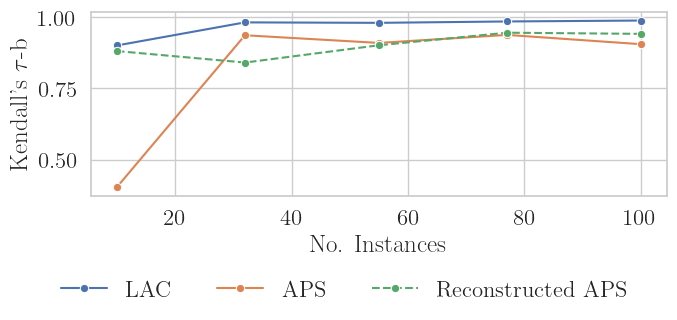

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 3)



fig, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel(r"Kendall's $\tau$-b")
ax.set_xlabel(r"No. Instances")
# ax.set_ylim([0.0,1])
sns.lineplot(x=num_instances_to_check, y=taus["lac"], ax = ax, marker="o",label="LAC", legend=False)
sns.lineplot(x=num_instances_to_check, y=taus["aps"], ax = ax, marker="o",label="APS", legend=False)
sns.lineplot(x=num_instances_to_check, y=taus["own_aps"], ax = ax, marker="o",label="Reconstructed APS", legend=False, linestyle="--")
# sns.lineplot(x=num_instances_to_check, y=taus["rand_aps"], ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=taus["own_rand_aps"], ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_own_aps, ax = ax, marker="o",label="Reconstructed APS", linestyle="--", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_SAPS, ax = ax, marker="o", label="SAPS", legend=False)
lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)

fig.tight_layout() 
plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])

In [27]:
skills_from_model = model_lac(X_test)
y_test = torch.tensor(y_test, device="cuda")
skills_from_model = skills_from_model - skills_from_model.min()
skills_from_model = skills_from_model / (skills_from_model.max() - skills_from_model.min())
own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
y_test = torch.tensor(y_test, device="cuda")
own_aps = aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
# own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
aps_scores = oracle_annotator_aps.get_conformity(X_test, y_test).detach().cpu().numpy()
tau_corr, p_value = kendalltau(own_aps, aps_scores)

NameError: name 'model_lac' is not defined